<a href="https://colab.research.google.com/github/PallaviacharN/BITS_Recommendation_System/blob/main/Spam_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn
import pickle
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
data = pd.read_csv('spam.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
data = data.rename(columns={"v2" : "text", "v1":"label"})

In [6]:
data[1990:2000]

,label,text
1990,ham,HI DARLIN IVE JUST GOT BACK AND I HAD A REALLY...
1991,ham,No other Valentines huh? The proof is on your ...
1992,spam,Free tones Hope you enjoyed your new content. ...
1993,ham,Eh den sat u book e kb liao huh...
1994,ham,Have you been practising your curtsey?
1995,ham,Shall i come to get pickle
1996,ham,Lol boo I was hoping for a laugh
1997,ham,\YEH I AM DEF UP4 SOMETHING SAT
1998,ham,"Well, I have to leave for my class babe ... Yo..."
1999,ham,LMAO where's your fish memory when I need it?


In [7]:
data['label'].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

array([[<Axes: title={'center': 'length'}>]], dtype=object)

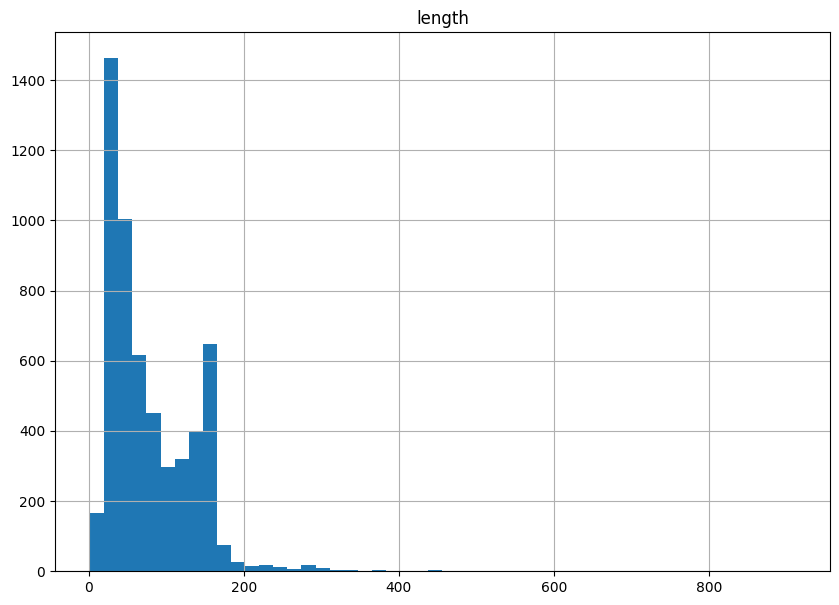

In [8]:
data['length'] = data['text'].map(lambda x: len(x))
data.hist(column='length',bins=50, figsize=(10,7))

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

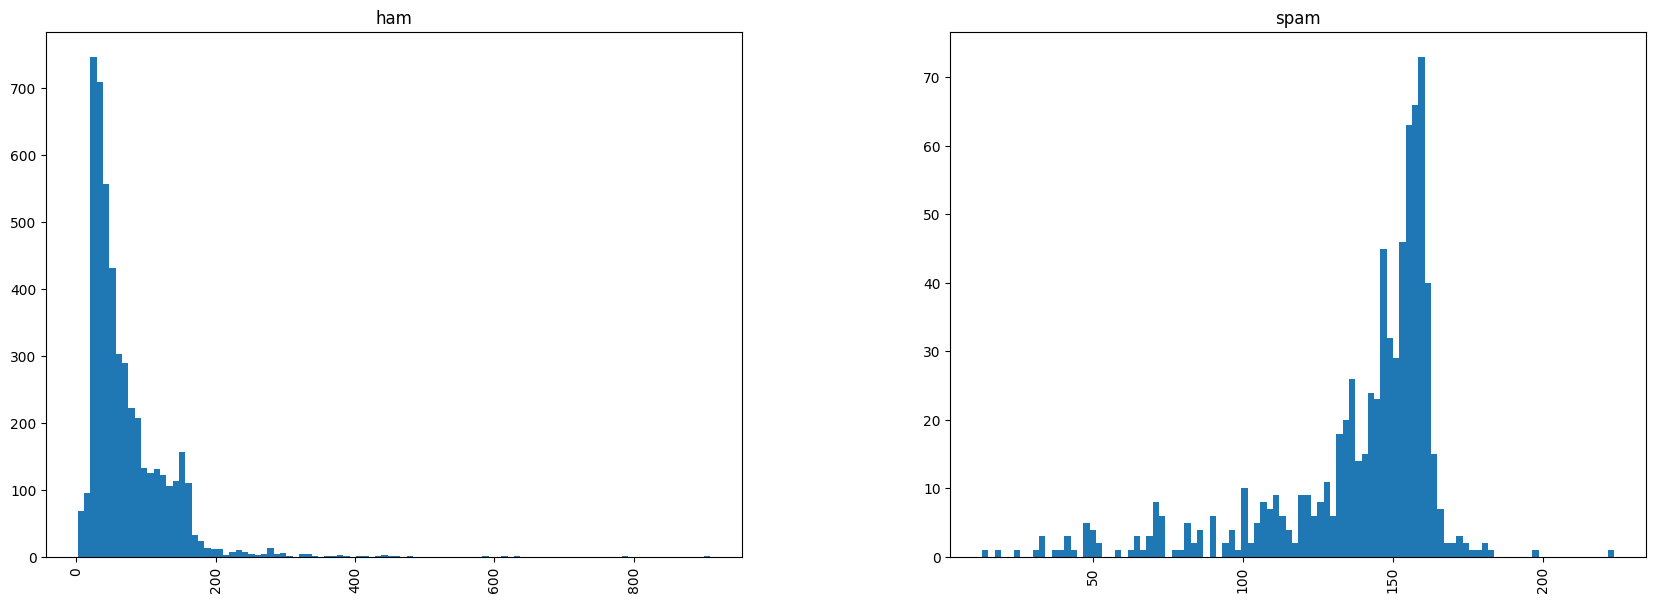

In [9]:
data.hist(column='length', by='label', bins=100, figsize=(20,7))

In [10]:
# import nltk
#nltk.download("punkt")
import warnings
warnings.filterwarnings('ignore')

In [11]:
ham_words = ''
spam_words = ''

In [12]:
for val in data[data['label'] == 'spam'].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        spam_words = spam_words + words + ' '

for val in data[data['label'] == 'ham'].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        ham_words = ham_words + words + ' '

In [13]:
spam_wordcloud = WordCloud(width=500, height=300).generate(spam_words)
ham_wordcloud = WordCloud(width=500, height=300).generate(ham_words)

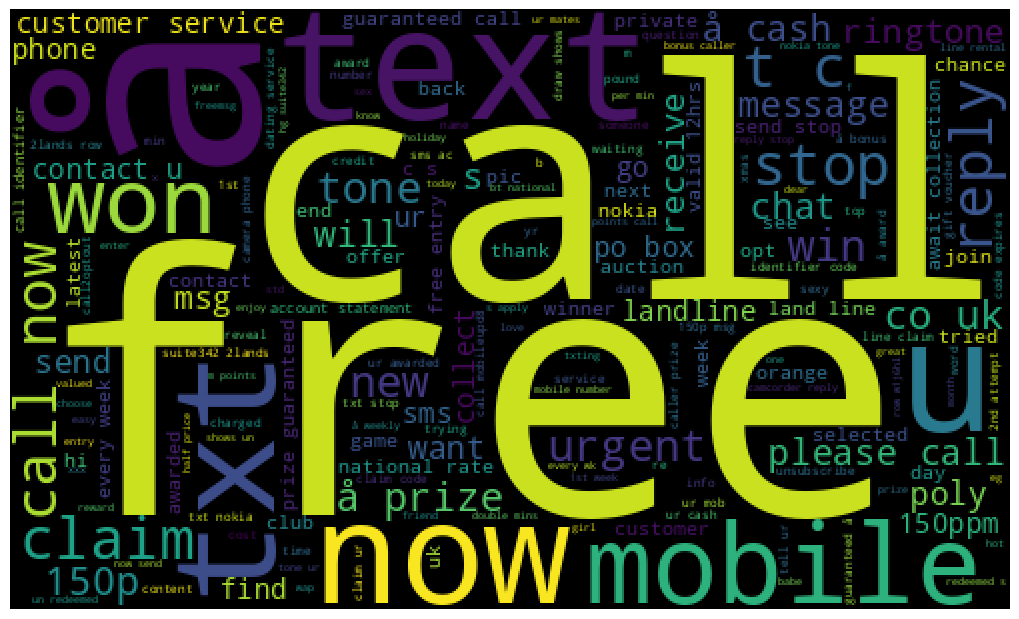

In [14]:
#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='w')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

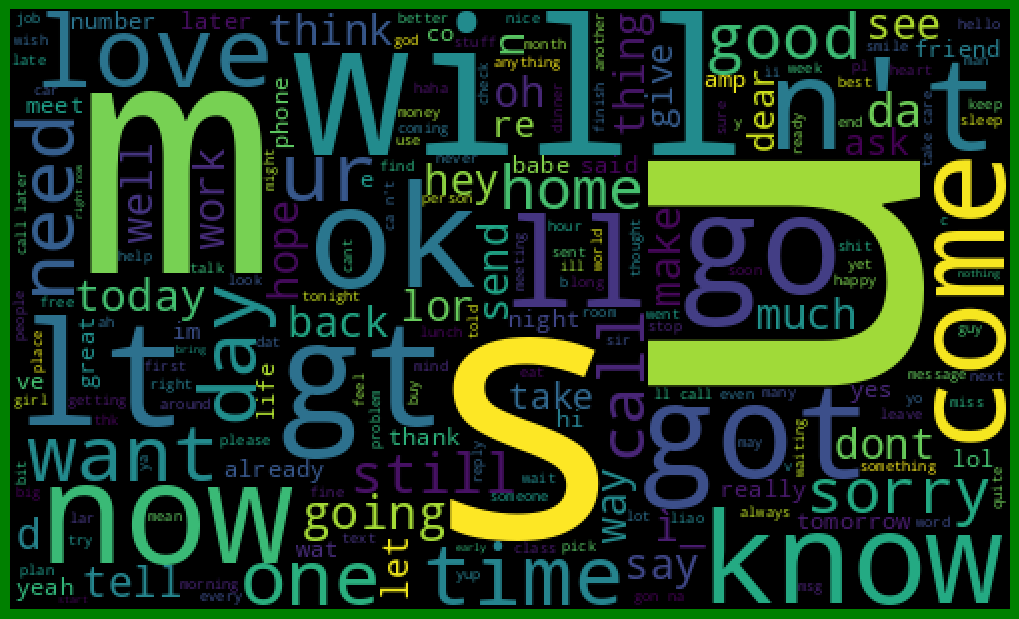

In [15]:
plt.figure( figsize=(10,8), facecolor='g')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [16]:
data = data.replace(['ham','spam'],[0, 1])

In [17]:
data.head(10)

,label,text,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61
5,1,FreeMsg Hey there darling it's been 3 week's n...,148
6,0,Even my brother is not like to speak with me. ...,77
7,0,As per your request 'Melle Melle (Oru Minnamin...,160
8,1,WINNER!! As a valued network customer you have...,158
9,1,Had your mobile 11 months or more? U R entitle...,154


In [18]:
def emoji(text):
    # Smile -- :), : ), :-), (:, ( :, (-:, :') , :O
    text = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positiveemoji ', text)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    text = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positiveemoji ', text)
    # Love -- <3, :*
    text = re.sub(r'(<3|:\*)', ' positiveemoji ', text)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-; , @-)
    text = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positiveemoji ', text)
    # Sad -- :-(, : (, :(, ):, )-:, :-/ , :-|
    text = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negetiveemoji ', text)
    # Cry -- :,(, :'(, :"(
    text = re.sub(r'(:,\(|:\'\(|:"\()', ' negetiveemoji ', text)
    return text

In [19]:
import re

def process_text_data(text):
    text = text.lower()                                             # Lowercases the string
    text = re.sub('@[^\s]+', '', text)                              # Removes usernames
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text)   # Remove URLs
    text = re.sub(r"\d+", " ", str(text))                           # Removes all digits
    text = re.sub('&quot;'," ", text)                               # Remove (&quot;)
    text = emoji(text)                                              # Replaces Emojis
    text = re.sub(r"\b[a-zA-Z]\b", "", str(text))                   # Removes all single characters

    text = re.sub(r"[^\w\s]", " ", str(text))                       # Removes all punctuations
    text = re.sub(r'(.)\1+', r'\1\1', text)                         # Convert more than 2 letter repetitions to 2 letter
    text = re.sub(r"\s+", " ", str(text))                           # Replaces double spaces with single space
    return text

In [20]:
data['processed_text'] = data['text'].apply(process_text_data)

In [ ]:
data

In [21]:
import string
def text_process(text):

    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]

    return " ".join(text)

In [22]:
data['processed_text'] = data['processed_text'].apply(text_process)

In [23]:
data.head()

,label,text,length,processed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazy available bugis great wo...
1,0,Ok lar... Joking wif u oni...,29,ok lar joking wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,49,dun say early hor already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah think goes usf lives around though


In [24]:
text = pd.DataFrame(data['processed_text'])
label = pd.DataFrame(data['label'])

In [25]:
# from textblob import TextBlob
# data['processed_text'].apply(lambda x: str(TextBlob(x).correct()))
# data.head(10)

In [26]:
# from nltk.stem.porter import *
# stemmer = PorterStemmer()

# data['processed_text'] =data['processed_text'].apply(lambda x: [stemmer.stem(i) for i in x])
# data['processed_text'].head()

In [27]:
# from nltk.stem.wordnet import WordNetLemmatizer
# lemmatizer = WordNetLemmatizer()

# data['processed_text'] =data['processed_text'].apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
# data.head()

In [28]:
text

,processed_text
0,go jurong point crazy available bugis great wo...
1,ok lar joking wif oni
2,free entry wkly comp win fa cup final tkts st ...
3,dun say early hor already say
4,nah think goes usf lives around though
...,...
5567,nd time tried contact å pound prize claim easy...
5568,ì going esplanade fr home
5569,pity mood suggestions
5570,guy bitching acted like interested buying some...


In [29]:
## Counting how many times a word appears in the dataset

from collections import Counter

total_counts = Counter()
for i in range(len(text)):
    for word in text.values[i][0].split(" "):
        total_counts[word] += 1

print("Total words in data set: ", len(total_counts))

Total words in data set:  7511


In [30]:
## Sorting in decreasing order (Word with highest frequency appears first)
vocab = sorted(total_counts, key=total_counts.get, reverse=True)
print(vocab[:60])

['call', 'get', 'ur', 'positiveemoji', 'gt', 'lt', 'å', 'ok', 'free', 'go', 'know', 'like', 'good', 'got', 'day', 'come', 'time', 'love', 'send', 'want', 'text', 'txt', 'one', 'going', 'need', 'home', 'stop', 'lor', 'today', 'sorry', 'see', 'still', 'back', 'da', 'reply', 'mobile', 'dont', 'take', 'tell', 'hi', 'new', 'later', 'pls', 'please', 'think', 'phone', 'week', 'dear', 'ì', 'well', 'much', 'great', 'night', 'oh', 'claim', 'hope', 'hey', 'msg', 'wat', 'happy']


In [31]:
# Mapping from words to index

vocab_size = len(vocab)
word2idx = {}
#print vocab_size
for i, word in enumerate(vocab):
    word2idx[word] = i

In [32]:
### Text to Vector
def text_to_vector(text):
    word_vector = np.zeros(vocab_size)
    for word in text.split(" "):
        if word2idx.get(word) is None:
            continue
        else:
            word_vector[word2idx.get(word)] += 1
    return np.array(word_vector)

In [33]:
## Convert all titles to vectors
word_vectors = np.zeros((len(text), len(vocab)), dtype=np.int_)
for ii, (_, text_) in enumerate(text.iterrows()):
    word_vectors[ii] = text_to_vector(text_[0])

In [34]:
word_vectors.shape

(5572, 7511)

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data['text'])
vectors.shape

(5572, 8672)

In [36]:
#features = word_vectors
features = vectors

In [37]:
features

<5572x8672 sparse matrix of type '<class 'numpy.float64'>'
	with 73916 stored elements in Compressed Sparse Row format>

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, data['label'], test_size=0.15, random_state=111)

In [39]:
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(4736, 8672)
(836, 8672)
(4736,)
(836,)


In [40]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy={1:4000}, random_state=42)

X_train, y_train = smote.fit_resample(X_train.astype('float'), y_train)
print("Before SMOTE:", Counter(y_train))
# print("After SMOTE:", Counter(y_train_smote))

Before SMOTE: Counter({0: 4100, 1: 4000})


In [41]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'error'
params['eta'] = 0.02
params['max_depth'] = 10

d_train = xgb.DMatrix(X_train, label=y_train)

watchlist = [(d_train, 'train')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-error:0.02284
[10]	train-error:0.01642
[20]	train-error:0.01716
[30]	train-error:0.01642
[40]	train-error:0.01494
[50]	train-error:0.01272
[60]	train-error:0.01185
[70]	train-error:0.01074
[80]	train-error:0.00988
[90]	train-error:0.00914
[100]	train-error:0.00864
[110]	train-error:0.00802
[120]	train-error:0.00741
[130]	train-error:0.00704
[140]	train-error:0.00667
[150]	train-error:0.00605
[160]	train-error:0.00580
[170]	train-error:0.00568
[180]	train-error:0.00568
[190]	train-error:0.00543
[200]	train-error:0.00506
[210]	train-error:0.00469
[220]	train-error:0.00457
[230]	train-error:0.00432
[240]	train-error:0.00432
[250]	train-error:0.00420
[260]	train-error:0.00420
[270]	train-error:0.00407
[280]	train-error:0.00407
[290]	train-error:0.00407
[300]	train-error:0.00395
[310]	train-error:0.00370
[320]	train-error:0.00370
[330]	train-error:0.00346
[340]	train-error:0.00333
[350]	train-error:0.00333
[360]	train-error:0.00309
[370]	train-error:0.00284
[380]	train-error:0.002

In [42]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'error'
params['eta'] = 0.02
params['max_depth'] = 10

d_train = xgb.DMatrix(X_train, label=y_train)

watchlist = [(d_train, 'train')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=400, verbose_eval=10)

[0]	train-error:0.02284
[10]	train-error:0.01642
[20]	train-error:0.01716
[30]	train-error:0.01642
[40]	train-error:0.01494
[50]	train-error:0.01272
[60]	train-error:0.01185
[70]	train-error:0.01074
[80]	train-error:0.00988
[90]	train-error:0.00914
[100]	train-error:0.00864
[110]	train-error:0.00802
[120]	train-error:0.00741
[130]	train-error:0.00704
[140]	train-error:0.00667
[150]	train-error:0.00605
[160]	train-error:0.00580
[170]	train-error:0.00568
[180]	train-error:0.00568
[190]	train-error:0.00543
[200]	train-error:0.00506
[210]	train-error:0.00469
[220]	train-error:0.00457
[230]	train-error:0.00432
[240]	train-error:0.00432
[250]	train-error:0.00420
[260]	train-error:0.00420
[270]	train-error:0.00407
[280]	train-error:0.00407
[290]	train-error:0.00407
[300]	train-error:0.00395
[310]	train-error:0.00370
[320]	train-error:0.00370
[330]	train-error:0.00346
[340]	train-error:0.00333
[350]	train-error:0.00333
[360]	train-error:0.00309
[370]	train-error:0.00284
[380]	train-error:0.002

In [43]:
from sklearn.metrics import accuracy_score

# Predict values for test set
d_test = xgb.DMatrix(X_test)
p_test = bst.predict(d_test)

# Apply function round() to each element in np array
# so predictions are all either 0 or 1.
npround = np.vectorize(round)
p_test_ints = npround(p_test)

# Error rate for test set
accuracy = accuracy_score(y_test, p_test_ints)
print("Test Accuracy: ", accuracy)

Test Accuracy:  0.9868421052631579


In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_test, p_test_ints))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       725
           1       0.95      0.95      0.95       111

    accuracy                           0.99       836
   macro avg       0.97      0.97      0.97       836
weighted avg       0.99      0.99      0.99       836



In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [46]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)

In [47]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc}

In [48]:
def train(clf, features, targets):
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))

In [49]:
pred_scores_word_vectors = []
for k,v in clfs.items():
    train(v, X_train, y_train)
    pred = predict(v, X_test)
    pred_scores_word_vectors.append((k, [accuracy_score(y_test , pred)]))

In [50]:
predictions = pd.DataFrame.from_dict(dict(pred_scores_word_vectors),orient='index', columns=['Score'])
predictions
# DataFrame.from_dict(dict(items))

,Score
SVC,0.991627
KN,0.224880
NB,0.992823
DT,0.967703
LR,0.976077
RF,0.986842


In [51]:
predictions_word_vectors = pd.DataFrame.from_dict(dict(pred_scores_word_vectors),orient='index', columns=['Score_'])
predictions_word_vectors

,Score_
SVC,0.991627
KN,0.224880
NB,0.992823
DT,0.967703
LR,0.976077
RF,0.986842


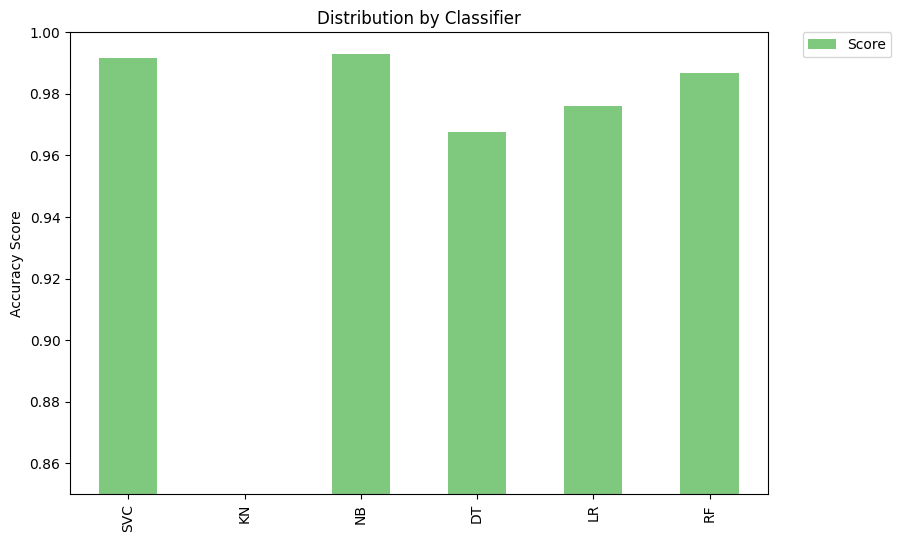

In [52]:
predictions.plot(kind='bar', ylim=(0.85,1.0), figsize=(9,6), align='center', colormap="Accent")
plt.xticks(np.arange(6), predictions.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

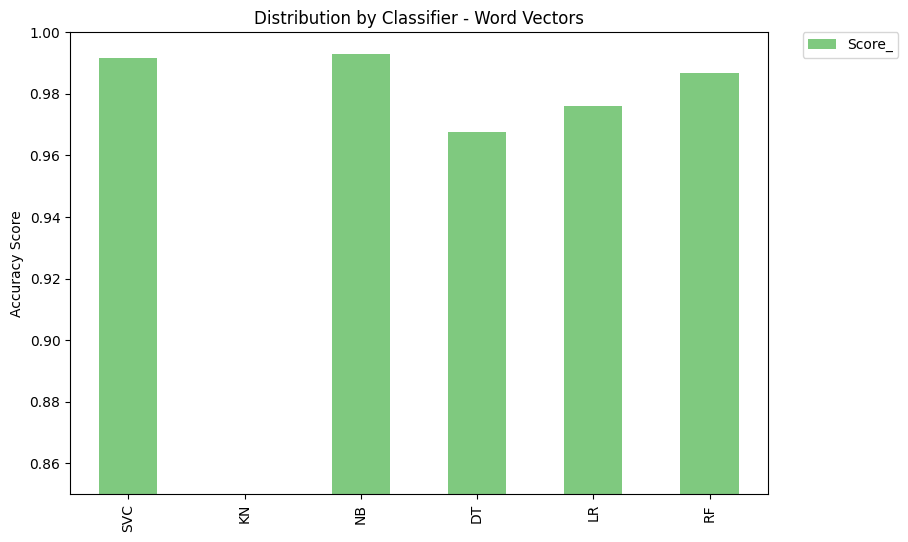

In [53]:
predictions_word_vectors.plot(kind='bar', ylim=(0.85,1.0), figsize=(9,6), align='center', colormap="Accent")
plt.xticks(np.arange(6), predictions_word_vectors.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier - Word Vectors')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [54]:
def find(p):
    if p == 1:
        print ("Message is SPAM")
    else:
        print ("Message is NOT Spam")

In [55]:
text = ["Free tones Hope you enjoyed your new content"]
integers = vectorizer.transform(text)

In [56]:
p = mnb.predict(integers)[0]
find(p)

Message is SPAM


In [57]:
import joblib
joblib.dump(mnb, 'best.pkl')
print ("Best Model (Naive Bayes) Saved")

Best Model (Naive Bayes) Saved


In [58]:
best = joblib.load('best.pkl')

In [59]:
best

MultinomialNB(alpha=0.2)

In [60]:
def test_pre(text):
  text = process_text_data(text)
  text = text_process(text)
  text = text.split("\n")
  print(text)
  return text


In [61]:
text1 = "hi how are you this msg is regarding to your job application"
text2 = "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
text3 = "Had your contract mobile 11 Mnths? Latest Motorola Now"
text4 = "Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030"

text1 = test_pre(text1)
text2 = test_pre(text2)
text3 = test_pre(text3)
text4 = test_pre(text4)




integers1 = vectorizer.transform(text1)
integers2 = vectorizer.transform(text2)
integers3 = vectorizer.transform(text3)
integers4 = vectorizer.transform(text4)

['hi msg regarding job application']
['go jurong point crazy available bugis great world la buffet cine got amore wat']
['contract mobile mnths latest motorola']
['mobile months entitled update latest colour mobiles camera free call mobile update co free']


In [62]:
p1 = best.predict(integers1)[0]
p2 = best.predict(integers2)[0]
p3 = best.predict(integers3)[0]
p4 = best.predict(integers4)[0]

find(p1)
find(p2)
find(p3)
find(p4)
print(p1)
print(p2)
print(p3)
print(p4)

Message is NOT Spam
Message is NOT Spam
Message is SPAM
Message is SPAM
0
0
1
1
